In [1]:
import line_profiler
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import sys
from tqdm import tqdm
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *


In [12]:
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/10h/data_0000.root' ## later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing

df_hits = load_dataset(file_path)
og_len = len(df_hits)
df_hits.query('n_hits > 6', inplace=True)
df_hits.query('n_hits < 50', inplace=True)
new_len = len(df_hits)
print('selected {:.2f}% of all events'.format(new_len/og_len * 100))

selected 5.14% of all events


In [3]:
## This function provide the parameters x0 (or y0 depending on which hits we provide) and tx the angle of the trac
def create_tracks(df, plot = False):
    tracks = []
    nb_events = len(df['n_hits'])
    steps = 9
    buff_start = None
    buff_evt_idx = None
    dts = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0]):
        channels = row['tofpet_channel']
        tofpet_id = row['tofpet_id']
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D(hits)
            tracks.append(track)

            ## check if track has a "good" chi2 value
            if track.is_good_2D_fit():
            
                # worth making a precise track
                #track.precise_track()
                
                ## compute the time of the track
                dt = track.get_time_interval()
                if dt is not None:
                    dts.append(dt)


    return tracks, dts
    

In [4]:
# getting tracks
tracks, dts = create_tracks(df_hits.head(100))
# %reload_ext line_profiler
# %lprun -f create_tracks create_tracks(df_hits.head(10))

100%|██████████| 100/100 [00:02<00:00, 37.81it/s]


####### Track # 7
Reduced chi^2 = 0.54
t = -0.32,	 x0 = 2.92
Reduced chi^2 = 2.26
t = 1.27,	 x0 = 3.75


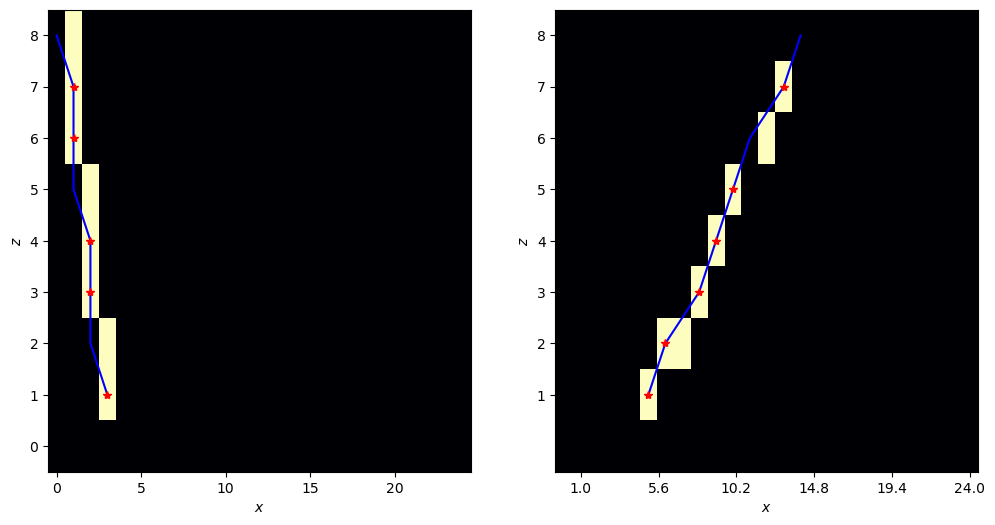

In [5]:
# testing individual outputs
good_tracks = [t for t in tracks if t.is_good_2D_fit()]
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
t.print(True)
# t.precise_track()
# print('after')
# t.print(True)

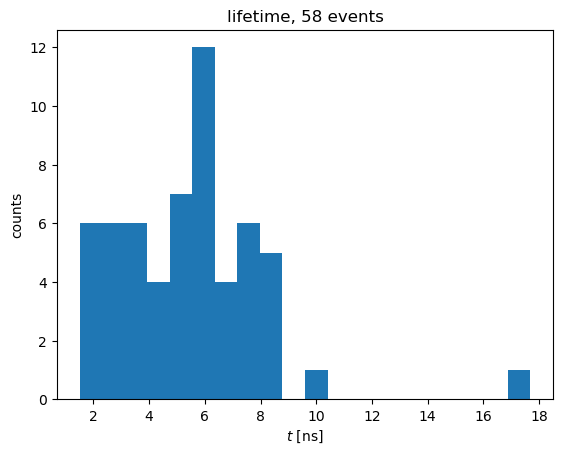

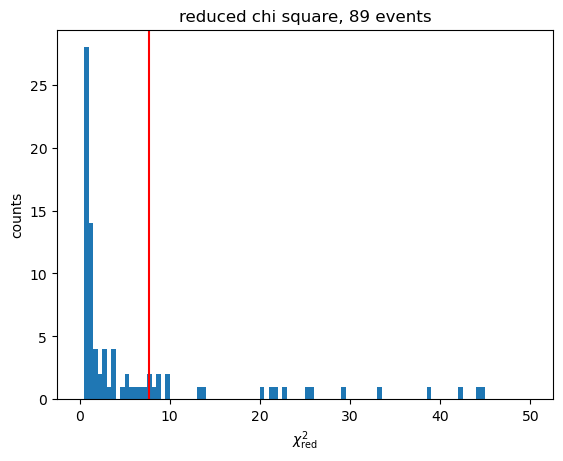

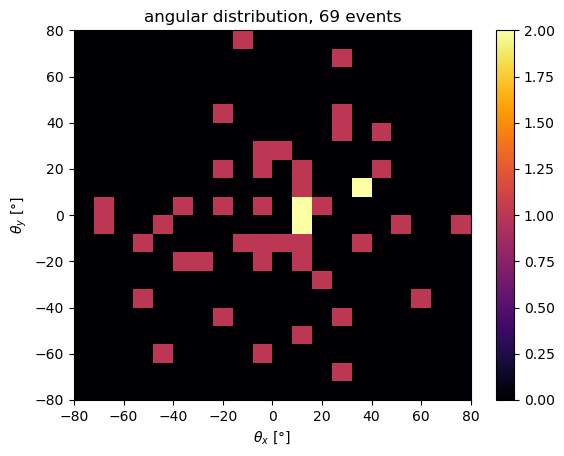

In [6]:
# plotting lifetime and reduced chi-square distribution
plt.figure()
plt.title('lifetime, {} events'.format(len(dts)))
plt.hist(np.array(dts)*6.25, bins = 20)
# plt.yscale('log')
plt.xlabel('$t$ [ns]')
plt.ylabel('counts')

chi_squares = [track.reduced_chi2() for track in tracks if track.reduced_chi2() is not None]
plt.figure()
plt.title('reduced chi square, {} events'.format(len(chi_squares)))
plt.hist(chi_squares, bins = 100, range = [0, 50])
plt.axvline(x = 2 * 3.841, ymin = 0.0, ymax = 1.0, color = 'r')
plt.xlabel('$\chi^2_{\mathrm{red}}$')
plt.ylabel('counts')

thetas_x = [np.tan(t.x.t) * 180 / np.pi for t in tracks if t.is_good_2D_fit()]
thetas_y = [np.tan(t.y.t) * 180 / np.pi for t in tracks if t.is_good_2D_fit()]
plt.figure()
plt.title('angular distribution, {} events'.format(len(thetas_x)))
plt.hist2d(thetas_x, thetas_y, bins = 20, range = [[-80, 80], [-80, 80]], cmap = 'inferno')
plt.xlabel(r"$\theta_x$ [°]")
plt.ylabel(r"$\theta_y$ [°]")
plt.colorbar()

####### Track # 81
[0, 1]
[3, 2, 4, 0]


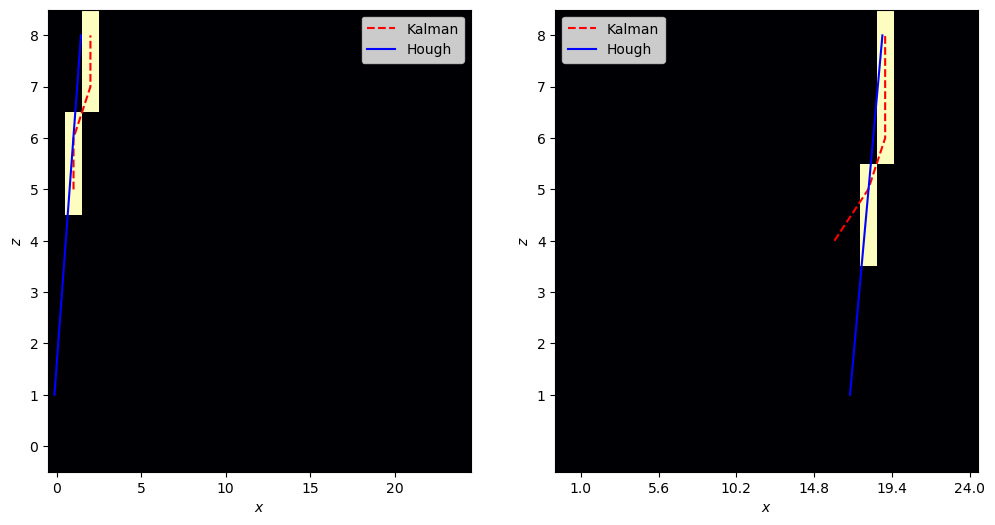

In [31]:
# testing the Kalman filter
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
t.kalman_filter()